In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

df_train = pd.read_csv("politicES_phase_2_train_public.csv", on_bad_lines='skip')

In [ ]:
df_train['tweet'] = df_train.apply(lambda row: row['gender'] + " " + row['profession']+ " " + row['ideology_multiclass']+ " " + row['tweet'], axis=1)
df_train.drop(['ideology_multiclass','gender','profession','label'], axis=1, inplace=True)

##  Clasificador

In [ ]:
!pip install datasets
!pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.3 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 7.0 MB/s eta 0:00:00


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, generation, DataCollatorWithPadding, TrainingArguments, Trainer, EarlyStoppingCallback
import torch
import tensorflow as tf
from datasets import Dataset
import tqdm as notebook_tqdm

model_name = 'AIDA-UPM/BERTuit-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2, from_tf=True)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/562 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/483k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/283k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/821 [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/529M [00:00<?, ?B/s]

All TF 2.0 model weights were used when initializing RobertaForSequenceClassification.

All the weights of RobertaForSequenceClassification were initialized from the TF 2.0 model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use RobertaForSequenceClassification for predictions without further training.


In [ ]:
label_encoder = LabelEncoder()

df_train['ideology_binary'] = label_encoder.fit_transform(df_train['ideology_binary'])

df_train['tweet'] = df_train['tweet'].apply(lambda x: x.replace("@user", "<usr>"))

df_train, df_eval= train_test_split(df_train, test_size=0.2, stratify= df_train['ideology_binary'], random_state=42)

In [ ]:
def tokenize_function(example):
    return tokenizer(example['tweet'])

dataset_train = Dataset.from_pandas(df_train)
dataset_eval = Dataset.from_pandas(df_eval)

In [ ]:
# Aplicamos la tokenización a todo el dataset
tokenized_dataset_train = dataset_train.map(tokenize_function, batched=True)
tokenized_dataset_eval = dataset_eval.map(tokenize_function, batched=True)
tokenized_dataset_train

Map:   0%|          | 0/144000 [00:00<?, ? examples/s]

Map:   0%|          | 0/36000 [00:00<?, ? examples/s]

Dataset({
    features: ['ideology_multiclass', 'tweet', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 144000
})

In [ ]:
tokenized_dataset_train= tokenized_dataset_train.rename_column("ideology_binary", "labels")
tokenized_dataset_train= tokenized_dataset_train.remove_columns(["tweet","__index_level_0__"])

tokenized_dataset_eval= tokenized_dataset_eval.rename_column("ideology_binary", "labels")
tokenized_dataset_eval= tokenized_dataset_eval.remove_columns(["tweet","__index_level_0__"])  # Nos quedamos solo con los valores que necesita el modelo
tokenized_dataset_train

Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 144000
})

In [ ]:
from datasets import DatasetDict


# Creamos un DatasetDict para organizar los subconjuntos
final_datasets = DatasetDict({
    'train': tokenized_dataset_train,
    'validation': tokenized_dataset_eval,

})

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)  # Introducimos el data collator para trabajar con padding dinámico


You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Macro-f1
1750,0.557400,0.508863,0.653865
3500,0.470300,0.445721,0.706919
5250,0.437400,0.421332,0.761903
7000,0.422200,0.405591,0.767157
8750,0.410300,0.392387,0.782044
10500,0.340100,0.418319,0.781117


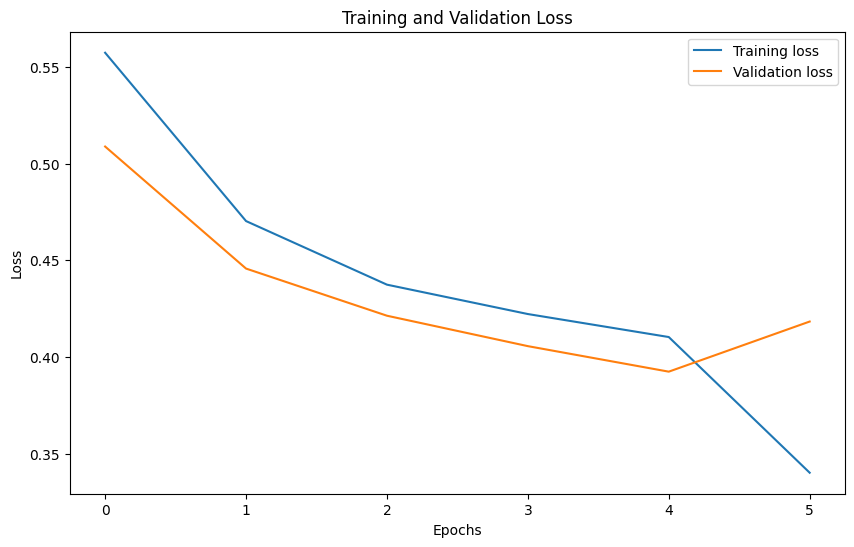

In [ ]:

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
import matplotlib.pyplot as plt

# Definimos la función encargada de evaluar las métricas en el entrenamiento
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=-1)
    macro_f1 = f1_score(labels, predictions, average='macro') # o weighted si estan desbalceadas las clases

    return {'macro-F1': macro_f1}



# Definimos los argumentos de entrenamiento
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.01,
    evaluation_strategy='steps',
    eval_steps=1750,
    save_strategy='steps',
    save_steps=1750,
    logging_strategy='steps',
    logging_dir='./logs',
    logging_steps=1750,
    load_best_model_at_end=True,
    seed=42,
)

# Inicializamos el Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=final_datasets['train'],
    eval_dataset=final_datasets['validation'],
    compute_metrics=compute_metrics,
    data_collator=data_collator,
    tokenizer=tokenizer,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=1, early_stopping_threshold=0)]
)

# Entrenamiento y evaluación
trainer.train()
training_stats = trainer.state.log_history

# Representación de las pérdidas a lo largo de las épocas
training_loss = [e['loss'] for e in training_stats if 'loss' in e]
validation_loss = [e['eval_loss'] for e in training_stats if 'eval_loss' in e]

plt.figure(figsize=(10, 6))
plt.plot(training_loss, label='Training loss')
plt.plot(validation_loss, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from huggingface_hub import notebook_login

In [ ]:
notebook_login()

In [ ]:
model.save_pretrained("BERTuit-ideologiabin-all", push_to_hub=True)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [ ]:
tokenizer.save_pretrained("BERTuit-ideologiabin-all", push_to_hub=True)

('ideology-BERTuit-base-all-f1/tokenizer_config.json',
 'ideology-BERTuit-base-all-f1/special_tokens_map.json',
 'ideology-BERTuit-base-all-f1/vocab.json',
 'ideology-BERTuit-base-all-f1/merges.txt',
 'ideology-BERTuit-base-all-f1/added_tokens.json',
 'ideology-BERTuit-base-all-f1/tokenizer.json')